# Tanzania Water Pump Prediction Modeling

<img src="images/Drinking-Water.jpeg" width=50% align="left"/>
<img src='images/hand_pump_diagram.png' width=30% alight='right'/>

# 1. Overview
---
4 million people in Tanzania lack access to safe water. Access to clean water is a fundamental human necessity and not having that access is a serious health risk. Our initial dataset shows that almost 40% of water pumps throughout regions of Tanzania are not functional, and an additional 7% need repairs.

In this project, I aim to create a model that will most accurately predict which water pumps are functional, which need repairs, and which need to be replaced completely. To make these predictions, I will start with a baseline machine learning model, then testing and fine-tuning more efficiant models and optimizing hyperparameters. 

My analysis began with a simple Logistic Regression Model, then used a Random Forest Model with parameters tuned, and then the final and most efficient analysis was an XGBoost Model. My final model was able to produce a score of __ % taking into consideration the decision to prioritize false negatives. 

# 2. Business Problem
---
Using data gathered from Taarifa and the Tanzanian Ministry of Water, I have been tasked with analyzing the different features corresponding to functional and non functional water pumps with the goal of creating a model that can predict if a pump needs to be replaced. The stakeholder for this project is the World Health Organization and the data was provided by the Taarifa waterpoints dashboard. 

Through my analysis it is important not to just create an accurate prediction model, but to assess our criteria for what an accurate model will look like. Because we are dealing with human health and life, it is important that we use a conservative model. We want to prioritize replacement over not replacement because our business cost is peoples well being. Therefore, for any false predictions our model makes, we want to prioritize False "not functional" (False Negative) over False "functional" (False Positive). This is because the risks are higher for not replacing a pump that needs replacing, over replacing a pump that didn't actually need to be replaced. This is so we can ensure that clean, potable water is available to communities across Tanzania.

This analysis will be used to implement an actionable plan for fixing and replacing water pumps throughout Tanzania.

# 3. Data Understanding
--- 
This projects datasets came from the Taarifa: an open source platform for the crowd sourced reporting and triaging of infrastructure related issues.

These datasets contain information about 59,400 water pumps throughout Tanzania. The first dataset contains ID numbers and feature information about each water pump. The second dataset contained ID numbers and pump condition for each water pump

**Pump Features:**<br>
```amount_tsh``` - Total static head (amount water available to waterpoint)<br>
```date_recorded``` - The date the row was entered<br>
```funder``` - Who funded the well<br>
```gps_height``` - Altitude of the well<br>
```installer``` - Organization that installed the well<br>
```longitude``` - GPS coordinate<br>
```latitude``` - GPS coordinate<br>
```wpt_name``` - Name of the waterpoint if there is one<br>
```num_private``` -<br>
```basin``` - Geographic water basin<br>
```subvillage``` - Geographic location<br>
```region``` - Geographic location<br>
```region_code``` - Geographic location (coded)<br>
```district_code``` - Geographic location (coded)<br>
```lga``` - Geographic location<br>
```ward``` - Geographic location<br>
```population``` - Population around the well<br>
```public_meeting``` - True/False<br>
```recorded_by``` - Group entering this row of data<br>
```scheme_management``` - Who operates the waterpoint<br>
```scheme_name``` - Who operates the waterpoint<br>
```permit``` - If the waterpoint is permitted<br>
```construction_year``` - Year the waterpoint was constructed<br>
```extraction_type``` - The kind of extraction the waterpoint uses<br>
```extraction_type_group``` - The kind of extraction the waterpoint uses<br>
```extraction_type_class``` - The kind of extraction the waterpoint uses<br>
```management``` - How the waterpoint is managed<br>
```management_group``` - How the waterpoint is managed<br>
```payment``` - What the water costs<br>
```payment_type``` - What the water costs<br>
```water_quality``` - The quality of the water<br>
```quality_group``` - The quality of the water<br>
```quantity``` - The quantity of water<br>
```quantity_group``` - The quantity of water<br>
```source``` - The source of the water<br>
```source_type``` - The source of the water<br>
```source_class``` - The source of the water<br>
```waterpoint_type``` - The kind of waterpoint<br>
```waterpoint_type_group``` - The kind of waterpoint<br>


**Pump Conditions:**<br>
```functional``` - the waterpoint is operational and there are no repairs needed<br>
```functional needs repair``` - the waterpoint is operational, but needs repairs<br>
```non functional``` - the waterpoint is not operational

# 4. Data Preparation

### Import Packages

In [879]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from yellowbrick.classifier import ROCAUC, ClassificationReport

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, accuracy_score, recall_score, f1_score, precision_score,\
    classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as Pipe

from xgboost import XGBClassifier

#### Read in CSV datasets

In [880]:
pump_vals = pd.read_csv('data/training_values.csv')
pump_labels = pd.read_csv('data/training_labels.csv')

In [881]:
pump_vals.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [882]:
pump_vals.shape

(59400, 40)

In [883]:
pump_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [884]:
pump_labels.shape

(59400, 2)

#### Merge value and label datasets

In [885]:
pump_df = pd.merge(left=pump_vals, right=pump_labels, how='inner', on='id')
pump_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [886]:
pump_df.shape

(59400, 41)

# 5. Data Cleaning

In [887]:
pump_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [888]:
pump_df.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [889]:
# drop scheme name because it contains almost half NULL values
pump_df = pump_df.drop('scheme_name', axis=1)

#### Drop any redundant columns or columns that are not relevant

In [890]:
pump_df = pump_df.drop(['funder', 'subvillage', 'scheme_management'], axis=1)

In [891]:
# columns with redundancy or columns that will not be necessary for our modeling
drop_cols = ['quantity_group', 'quality_group', 'source_type', 'waterpoint_type_group', 'payment', \
             'extraction_type', 'extraction_type_group', 'recorded_by', 'region', 'amount_tsh', \
             'wpt_name', 'lga', 'ward', 'num_private', 'management_group', 'id']

pump_df = pump_df.drop(drop_cols, axis=1)

#### Fill Null values with either mean value or filler value (for installer column)

In [892]:
pump_df = pump_df.fillna(value={'permit': False, 'public_meeting': True, 'installer': 'N/A'})

In [893]:
pump_df.head()

,date_recorded,gps_height,installer,longitude,latitude,basin,region_code,district_code,population,public_meeting,...,construction_year,extraction_type_class,management,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_group
0,2011-03-14,1390,Roman,34.938093,-9.856322,Lake Nyasa,11,5,109,True,...,1999,gravity,vwc,annually,soft,enough,spring,groundwater,communal standpipe,functional
1,2013-03-06,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,20,2,280,True,...,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,2013-02-25,686,World vision,37.460664,-3.821329,Pangani,21,4,250,True,...,2009,gravity,vwc,per bucket,soft,enough,dam,surface,communal standpipe multiple,functional
3,2013-01-28,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,58,True,...,1986,submersible,vwc,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,2011-07-13,0,Artisan,31.130847,-1.825359,Lake Victoria,18,1,0,True,...,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional


#### Now that we have removed and replicative columns and cleaned up missing data, we have to dive deeper into what value types and ranges our final columns have. Are there any 0's in place that are just there as 'fillers'?

In [894]:
# convert all 0 to NaN and then convert other years into 'ages' and then fill NaN in with average age
pump_df.construction_year = pump_df.construction_year.replace(0, np.NaN)

pump_df['age'] = pump_df.construction_year.apply(lambda x: 2013 - x)
pump_df.age = pump_df.age.fillna(np.round(pump_df.age.mean()))

pump_df = pump_df.drop('construction_year', axis=1)

In [895]:
pump_df.head()

,date_recorded,gps_height,installer,longitude,latitude,basin,region_code,district_code,population,public_meeting,...,extraction_type_class,management,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_group,age
0,2011-03-14,1390,Roman,34.938093,-9.856322,Lake Nyasa,11,5,109,True,...,gravity,vwc,annually,soft,enough,spring,groundwater,communal standpipe,functional,14.0
1,2013-03-06,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,20,2,280,True,...,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional,3.0
2,2013-02-25,686,World vision,37.460664,-3.821329,Pangani,21,4,250,True,...,gravity,vwc,per bucket,soft,enough,dam,surface,communal standpipe multiple,functional,4.0
3,2013-01-28,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,58,True,...,submersible,vwc,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,non functional,27.0
4,2011-07-13,0,Artisan,31.130847,-1.825359,Lake Victoria,18,1,0,True,...,gravity,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional,16.0


In [896]:
# assign any population values of 0 to the population mean
pop_mean = pump_df[pump_df['population'] > 0].population.mean()
pump_df.population = np.where(pump_df.population == 0, pop_mean, pump_df.population)

In [897]:
# assign any gps_height values of 0 to the height mean
gps_mean = pump_df[pump_df['gps_height'] > 0].gps_height.mean()
pump_df.gps_height = np.where(pump_df.gps_height == 0, gps_mean, pump_df.gps_height)

In [898]:
# change permit and permit meeting from booleans into int
pump_df.public_meeting = pump_df.public_meeting.astype(int)
pump_df.permit = pump_df.permit.astype(int)

In [899]:
pump_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_recorded          59400 non-null  object 
 1   gps_height             59400 non-null  float64
 2   installer              59400 non-null  object 
 3   longitude              59400 non-null  float64
 4   latitude               59400 non-null  float64
 5   basin                  59400 non-null  object 
 6   region_code            59400 non-null  int64  
 7   district_code          59400 non-null  int64  
 8   population             59400 non-null  float64
 9   public_meeting         59400 non-null  int64  
 10  permit                 59400 non-null  int64  
 11  extraction_type_class  59400 non-null  object 
 12  management             59400 non-null  object 
 13  payment_type           59400 non-null  object 
 14  water_quality          59400 non-null  object 
 15  qu

In [900]:
# region code and district code. convert to string and then One Hot Encode later, because while they are numeric, 
# they represent categorical data
pump_df['region_code'] = pump_df['region_code'].astype(str)
pump_df['district_code'] = pump_df['district_code'].astype(str)

In [901]:
# convert status_group to functional=2, functional needs repair = 1, and non functional = 0
status = {'functional': 2, 'functional needs repair': 1, 'non functional': 0}

pump_df['target'] = pump_df['status_group'].map(status)
pump_df = pump_df.drop('status_group', axis=1)

In [902]:
pump_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_recorded          59400 non-null  object 
 1   gps_height             59400 non-null  float64
 2   installer              59400 non-null  object 
 3   longitude              59400 non-null  float64
 4   latitude               59400 non-null  float64
 5   basin                  59400 non-null  object 
 6   region_code            59400 non-null  object 
 7   district_code          59400 non-null  object 
 8   population             59400 non-null  float64
 9   public_meeting         59400 non-null  int64  
 10  permit                 59400 non-null  int64  
 11  extraction_type_class  59400 non-null  object 
 12  management             59400 non-null  object 
 13  payment_type           59400 non-null  object 
 14  water_quality          59400 non-null  object 
 15  qu

#### Convert date into date time and then take only year to signify age of pump record

In [903]:
pump_df.date_recorded = pd.to_datetime(pump_df['date_recorded'])

In [904]:
pump_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date_recorded          59400 non-null  datetime64[ns]
 1   gps_height             59400 non-null  float64       
 2   installer              59400 non-null  object        
 3   longitude              59400 non-null  float64       
 4   latitude               59400 non-null  float64       
 5   basin                  59400 non-null  object        
 6   region_code            59400 non-null  object        
 7   district_code          59400 non-null  object        
 8   population             59400 non-null  float64       
 9   public_meeting         59400 non-null  int64         
 10  permit                 59400 non-null  int64         
 11  extraction_type_class  59400 non-null  object        
 12  management             59400 non-null  object        
 13  p

In [905]:
pump_df['age_record'] = 2013-pump_df['date_recorded'].dt.year
pump_df = pump_df.drop('date_recorded', axis=1)

In [906]:
pump_df.describe()

,gps_height,longitude,latitude,population,public_meeting,permit,age,target,age_record
count,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,1033.133363,34.077427,-5.706033e+00,281.087167,0.914899,0.654074,16.120707,1.158838,1.078333
std,496.501747,6.567432,2.946019e+00,451.765813,0.279034,0.475673,10.066168,0.949794,0.958758
min,-90.000000,0.000000,-1.164944e+01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,903.000000,33.090347,-8.540621e+00,100.000000,1.000000,0.000000,9.000000,0.000000,0.000000
50%,1060.341803,34.908743,-5.021597e+00,281.087167,1.000000,1.000000,16.000000,2.000000,1.000000
75%,1319.250000,37.178387,-3.326156e+00,281.087167,1.000000,1.000000,17.000000,2.000000,2.000000
max,2770.000000,40.345193,-2.000000e-08,30500.000000,1.000000,1.000000,53.000000,2.000000,11.000000


In [907]:
pump_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gps_height             59400 non-null  float64
 1   installer              59400 non-null  object 
 2   longitude              59400 non-null  float64
 3   latitude               59400 non-null  float64
 4   basin                  59400 non-null  object 
 5   region_code            59400 non-null  object 
 6   district_code          59400 non-null  object 
 7   population             59400 non-null  float64
 8   public_meeting         59400 non-null  int64  
 9   permit                 59400 non-null  int64  
 10  extraction_type_class  59400 non-null  object 
 11  management             59400 non-null  object 
 12  payment_type           59400 non-null  object 
 13  water_quality          59400 non-null  object 
 14  quantity               59400 non-null  object 
 15  so

In [908]:
# uncomment to convert to csv file to map points in arcGIS
# pump_df.to_csv('data/pump_vals_lables.csv')

# 5. Train Test Split

#### Dataset has proven to be very large, and slow when running more complex models or Grid Searches. Cut down dataset for model testing

In [909]:
X = pump_df.drop(['target'], axis=1)
y = pump_df.target

In [910]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### One hot encode object type columns in train set

In [911]:
X_test_clean = ct.transform(X_test)


In [912]:
X_train_cat = X_train.select_dtypes('object')

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

dummy = ohe.fit_transform(X_train_cat)
dummy_df = pd.DataFrame(dummy, columns=ohe.get_feature_names(), index=X_train_cat.index)


In [913]:
X_train_nums = X_train.select_dtypes(include=['float64', 'int64'])

ss = StandardScaler()
scaled = ss.fit_transform(X_train_nums)


scaled_df = pd.DataFrame(scaled, index=X_train_nums.index)
scaled_df.columns = X_train_nums.columns

In [914]:
X_train_clean = pd.concat([scaled_df, dummy_df], axis=1)
X_train_clean

,gps_height,longitude,latitude,population,public_meeting,permit,age,age_record,x0_-,x0_0,...,x10_groundwater,x10_surface,x10_unknown,x11_cattle trough,x11_communal standpipe,x11_communal standpipe multiple,x11_dam,x11_hand pump,x11_improved spring,x11_other
43069,1.635537,0.105481,-1.162696,-0.546617,0.307594,0.728339,-1.202387,0.963380,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
58858,0.059212,-0.549544,0.996545,0.005512,0.307594,-1.372988,-0.011677,0.963380,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
41707,1.623499,0.177969,0.849083,-0.336137,0.307594,0.728339,-0.805483,-1.125659,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
30674,0.343432,0.668131,0.272582,-0.649519,0.307594,0.728339,2.171292,0.963380,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20944,-1.947848,0.794903,-0.448784,1.782697,0.307594,-1.372988,-1.301613,0.963380,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,-1.412146,0.346536,-1.041913,-0.055497,0.307594,0.728339,0.186775,0.963380,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
38158,1.428880,0.064069,-1.380354,-0.570004,0.307594,-1.372988,0.881356,0.963380,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
860,-2.094314,0.747756,0.099081,1.686812,-3.251043,-1.372988,-0.805483,0.963380,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15795,0.059212,0.030994,0.886178,0.005512,0.307594,0.728339,-0.011677,-0.081140,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### One Hot Encode object type columns in test set

In [915]:
X_test_cat = X_test.select_dtypes('object')

dummy = ohe.transform(X_test_cat)
dummy_df = pd.DataFrame(dummy, columns=ohe.get_feature_names(), index=X_test_cat.index)

In [916]:
X_test_nums = X_test.select_dtypes(include=['float64', 'int64'])

scaled = ss.transform(X_test_nums)

scaled_df = pd.DataFrame(scaled, index=X_test_nums.index)
scaled_df.columns = X_test_nums.columns

In [917]:
X_test_clean = pd.concat([scaled_df, dummy_df], axis=1)
X_test_clean

,gps_height,longitude,latitude,population,public_meeting,permit,age,age_record,x0_-,x0_0,...,x10_groundwater,x10_surface,x10_unknown,x11_cattle trough,x11_communal standpipe,x11_communal standpipe multiple,x11_dam,x11_hand pump,x11_improved spring,x11_other
2980,0.059212,-0.327697,0.719755,0.005512,0.307594,0.728339,-0.011677,-0.081140,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5246,0.059212,-0.197334,0.260975,0.005512,0.307594,0.728339,-0.011677,-0.081140,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22659,1.292447,0.211300,0.500095,-0.305734,0.307594,0.728339,-1.103161,-1.125659,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
39888,0.059212,-0.149936,-1.138742,0.005512,-3.251043,-1.372988,-0.011677,0.963380,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13361,0.156839,0.015681,0.435974,-0.102270,0.307594,0.728339,-1.400839,-1.125659,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13160,1.304485,0.270061,0.836932,-0.184124,0.307594,0.728339,-1.202387,-1.125659,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3852,0.059212,-0.134868,0.319328,0.005512,-3.251043,-1.372988,-0.011677,-1.125659,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
28598,2.012735,0.089798,-1.335730,-0.581697,0.307594,0.728339,-1.003935,0.963380,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43736,0.546075,-0.626893,0.338635,0.868277,0.307594,0.728339,-0.706258,-1.125659,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [918]:
# XGBoost classifier does not allow certain symbols in column names, the following code is to replace them with '_'
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train_clean.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_clean.columns.values]
X_test_clean.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test_clean.columns.values]


# 6. Modeling

### Logistic Regression: Use a baseline model as a starting point

In [919]:
y_train.value_counts(normalize=True)

2    0.541967
0    0.385305
1    0.072727
Name: target, dtype: float64

In [920]:
logreg = LogisticRegression(max_iter=10000, random_state=42)

logreg.fit(X_train_clean, y_train)
logreg.score(X_train_clean, y_train), logreg.score(X_test_clean, y_test)

(0.7686147186147186, 0.7613355780022447)

#### As we can see, Logistic Regression has a 76% accuracy for our baseline. That's pretty good! But lets see what that breakdown looks like

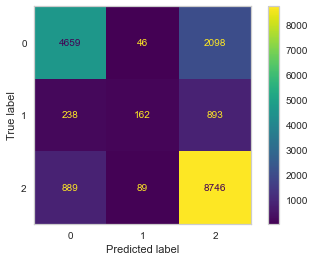

In [921]:
plot_confusion_matrix(logreg, X_test_clean, y_test);
plt.grid(False)

#### Looking closer we can see our model did a good job prodicting 2, a mediocre job at predicting 0, and a pretty poor job at predicting 1. Since we are trying to avoid false positives, this model needs to improve significantly Lets take a look at some other models. 

### Random Forset: Test out a model that handles large datasets well

In [922]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_clean, y_train)

rfc.score(X_train_clean, y_train), rfc.score(X_test_clean, y_test)

(0.9957431457431457, 0.7990460157126824)

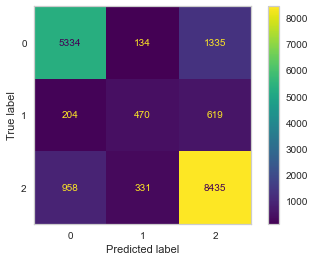

In [923]:
plot_confusion_matrix(rfc, X_test_clean, y_test);
plt.grid(False)

#### So far, using a decision tree seems to be a big improvement in score and in the confusion matrix. Let's tune our hyperparameters now and use Grid Search to find our best fitting parameters

In [924]:
rfc_params = {'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [1, 5, 10],
              'n_estimators': [100, 500, 1000],
              'max_depth': [5, 15, 30]}
              

In [925]:
# Uncomment to find best parameters - commented out for efficiency

# rfc_gs = GridSearchCV(estimator=rfc, param_grid=rfc_params, cv=5)

# rfc_gs.fit(X_train_clean, y_train)
# rfc_gs.score(X_train_clean, y_train), rfc_gs.score(X_test_clean, y_test)
print((0.9904761904761905, 0.7688888888888888))

(0.9904761904761905, 0.7688888888888888)


In [926]:
# best_parameters = rfc_gs.best_params_
# best_parameters
print({'criterion': 'entropy',
 'max_depth': 30,
 'min_samples_leaf': 1,
 'n_estimators': 1000})

{'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 1000}


#### Our grid search has provided us with optimal hyperparameters. Let's re-fit our model using these parameters

In [927]:
rfc_best = RandomForestClassifier(criterion='entropy', max_depth=30, \
                                  min_samples_leaf=1, n_estimators=100, random_state=42)

rfc_best.fit(X_train_clean, y_train)
rfc_best.score(X_train_clean, y_train), rfc_best.score(X_test_clean, y_test)

(0.946007696007696, 0.8062850729517396)

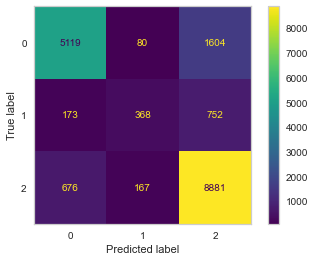

In [928]:
plot_confusion_matrix(rfc_best, X_test_clean, y_test);
plt.grid(False)

#### We have a slight imbalance in our datasets (specifically with 1: "Functional Needs Repair") so lets use SMOTE to fix some of that imbalance and see if we can improve our false positives!

In [929]:
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train_clean, y_train)
y_smote.value_counts()

0    22535
2    22535
1    22535
Name: target, dtype: int64

In [930]:
rfc_best.fit(X_smote, y_smote)
rfc_best.score(X_smote, y_smote), rfc_best.score(X_test_clean, y_test)

(0.9623252717994231, 0.7823793490460157)

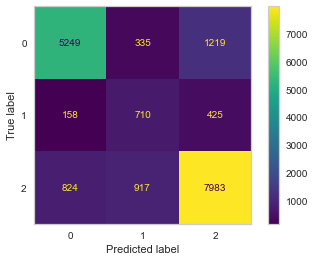

In [931]:
plot_confusion_matrix(rfc_best, X_test_clean, y_test);
plt.grid(False)

#### While our overall score might have decreased, if you look at the confusion matrix we can see that we have actually improved our chances of accurately predicting Non-Functional and Functional-Needs Repair pumps. Therefore we will consider this model to actually be an improvement

### XGBoost: We know that XGBoost is one of the most powerful models, so let's see how well it performs on our data!

In [932]:
clf = XGBClassifier()

clf.fit(X_train_clean, y_train)
clf.score(X_train_clean, y_train), clf.score(X_test_clean, y_test)

(0.8151515151515152, 0.7887205387205387)

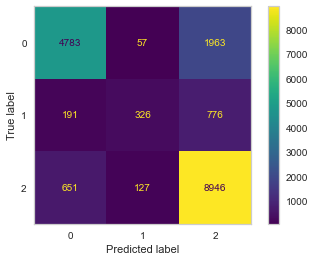

In [933]:
plot_confusion_matrix(clf, X_test_clean, y_test);
plt.grid(False)

#### So far, without any parameter tuning, this model performs slightly worse than Random Forest. Let's see how it does after we use SMOTE and try some hyperparameter tuning

In [934]:
clf_params = {'max_depth': [5, 10, 15],
    'n_estimators': [100, 150],
    'learning_rate': [0.2, 0.3]}

In [935]:
# clf_gs = GridSearchCV(estimator=clf, param_grid=clf_params, cv=5)

# clf_gs.fit(X_smote, y_smote)
# clf_gs.score(X_smote, y_smote), clf_gs.score(X_test_clean, y_test)
print((0.99026295842808, 0.7408888888888889))

(0.99026295842808, 0.7408888888888889)


In [936]:
# best_parameters = clf_gs.best_params_
# best_parameters
print({'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 100})

{'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 100}


#### Our grid search found the optimal hyperparameters for out model. Let's plug these back into our final XGBoost model

In [937]:
clf_best = XGBClassifier(learning_rate=0.2, max_depth=15, n_estimators=100)

clf_best.fit(X_smote, y_smote)
clf_best.score(X_smote, y_smote), clf_best.score(X_test_clean, y_test)

(0.9452407366319059, 0.7862514029180696)

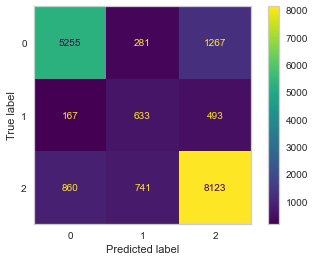

In [938]:
plot_confusion_matrix(clf_best, X_test_clean, y_test);
plt.grid(False)

#### This model provides us with our best prediction of Non-Fuctional and Functional-Needs Repair pipes, therefore we will consider this to be our final model.

### Lets look further at the metrics for each of our models to find the model thats best fit for our business requirements

In [939]:
def evaluate_model(model):
    model_pipe = Pipe(steps=[('smote', SMOTE(random_state=42)),
                             ('model', model)])
        
    model_pipe.fit(X_train_clean, y_train)
    y_pred = model.predict(X_test_clean)
    
    print(f"Model: {model} ")
    print("--------------------")
    print(f"Model Score: {round(model_pipe.score(X_test_clean, y_test),2)}")
    print(f"ROC AUC Score: {round(roc_auc_score(y_test, clf.predict_proba(X_test_clean), multi_class='ovr'), 2)}")
    
    print(f"Recall Score: {round(recall_score(y_test, y_pred, average='weighted'), 2)}")
    print(f"Precision Score: {round(precision_score(y_test, y_pred, average='weighted'), 2)}")
    print(f"F1 Score: {round(f1_score(y_test, y_pred, average='weighted'), 2)}")
    
    print(f"Classification Report: \n{classification_report(y_test, y_pred, digits=2)}")
    return model_pipe

models = [LogisticRegression(max_iter=10000, random_state=42),
          RandomForestClassifier(criterion='entropy', max_depth=30,min_samples_leaf=1, n_estimators=100, random_state=42), 
          XGBClassifier(learning_rate=0.2, max_depth=15, n_estimators=100)]
    
for model in models:
    evaluate_model(model)
    


Model: LogisticRegression(max_iter=10000, random_state=42) 
--------------------
Model Score: 0.65
ROC AUC Score: 0.89
Recall Score: 0.65
Precision Score: 0.76
F1 Score: 0.68
Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.66      0.72      6803
           1       0.20      0.70      0.31      1293
           2       0.80      0.63      0.71      9724

    accuracy                           0.65     17820
   macro avg       0.60      0.66      0.58     17820
weighted avg       0.76      0.65      0.68     17820

Model: RandomForestClassifier(criterion='entropy', max_depth=30, random_state=42) 
--------------------
Model Score: 0.78
ROC AUC Score: 0.89
Recall Score: 0.78
Precision Score: 0.8
F1 Score: 0.79
Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.77      0.81      6803
           1       0.36      0.55      0.44      1293
           2       0.83      0.82   

# 7. Evaluation

### Looking at the Classification Reports and different Scores for each model, it seems as though XGBoost and Random Forest have very close results - Random Forest Classifier does a better job at predicting 1 (Functional Needs Repair) but overall XGBoost has just slightly better overall scores. Either one would be an acceptable model

### I will choose Random Forest as the best model. It performed faster than XGBoost which is important for such a large dataset like this, but also it had less False Positive Predictions, which is what we're prioritizing tring to reduce. 

In [940]:
rf = RandomForestClassifier(criterion='entropy', max_depth=30,min_samples_leaf=1, n_estimators=100, random_state=42)

In [941]:
model = evaluate_model(rf)

Model: RandomForestClassifier(criterion='entropy', max_depth=30, random_state=42) 
--------------------
Model Score: 0.78
ROC AUC Score: 0.89
Recall Score: 0.78
Precision Score: 0.8
F1 Score: 0.79
Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.77      0.81      6803
           1       0.36      0.55      0.44      1293
           2       0.83      0.82      0.83      9724

    accuracy                           0.78     17820
   macro avg       0.68      0.71      0.69     17820
weighted avg       0.80      0.78      0.79     17820



#### Visualizations for our model

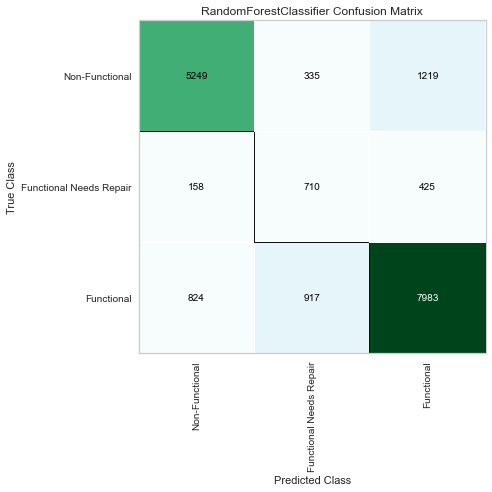

ConfusionMatrix(ax=<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=['Non-Functional', 'Functional Needs Repair',
                         'Functional'],
                cmap=<matplotlib.colors.ListedColormap object at 0x7fee9e61b790>,
                estimator=RandomForestClassifier(criterion='entropy',
                                                 max_depth=30,
                                                 random_state=42))

In [953]:
confusion_matrix(rf, X_smote, y_smote, X_test_clean, y_test, 
                 classes=['Non-Functional', 'Functional Needs Repair', 'Functional'], cmap='BuGn', size=(500,500))

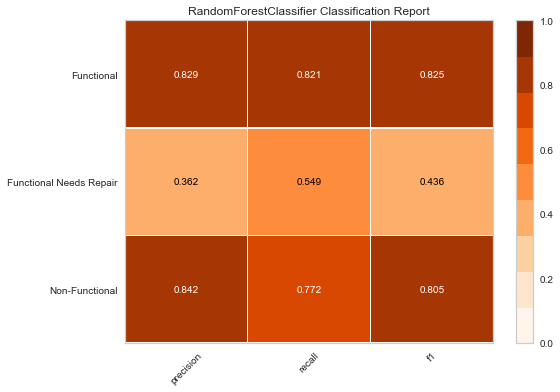

In [951]:
classif = ClassificationReport(rf, classes=['Non-Functional', 'Functional Needs Repair', 'Functional'], 
                               cmap='Oranges', size=(600, 400))
classif.fit(X_smote, y_smote)
classif.score(X_test_clean, y_test)
classif.show();

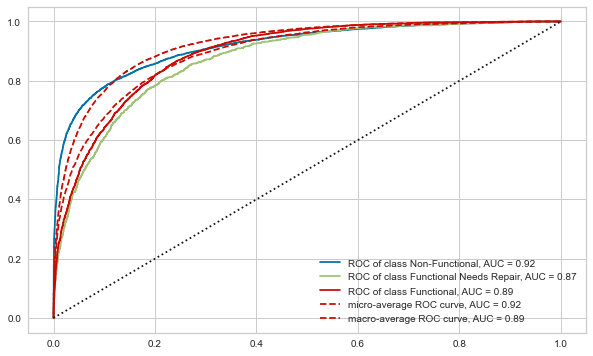

In [952]:
plt.figure(figsize=(10,6))
visualizer = ROCAUC(rf, classes=['Non-Functional', 'Functional Needs Repair', 'Functional'])
visualizer.fit(X_smote, y_smote)
visualizer.score(X_test_clean, y_test)
plt.legend();

# 8. Conclusion
---
The final model shows that we can with x% accuracy predict the condition of each water pump provided feature information. 

I chose the final model because of it's priority with classifying False Non-Functional, over False Functional. While this model is definitely not cost-effective, it will provide us with the most humanitarian solution. 

# 9. Further Steps
---
**Cost**<br>
Without any cost data we are unable to take into consideration the cost of our analysis when creating a prediction model. Acquiring cost data would allow us to show how much each decision would cost and would provide us with a more accurate cost-benefit analysis. It would be very influential in the decision to choose what type of model we want to prioritize. 

But with what we are given without cost data, we are going to prioritize human wellbeing. 

**Efficiency/Data Restrictions**<br>
Due to the number of categorical features, after One Hot Encoding, the dataframe was extremely large. I believe that with better resources I would have been able to use more features and produce an even more efficient model.
